
# Hybrid CNN–GNN for OCT (v4): GATv2 + Class-Specific Attention + EMA + Pseudo-Mask Segmentation

**What’s new vs v3**  
- **GATv2-style GNN** with **relative-position bias** on the 4-neighbor grid → sharper context propagation.  
- **Class-specific attention** (C attention maps) instead of class-agnostic → clearer per-class localization.  
- **EMA (Exponential Moving Average) teacher** of model parameters → stabler attention & pseudo masks at test time.  
- Keeps **pseudo-mask training with partial CE + Dice**, **edge-aware TV**, **adversarial erasing**, **sufficiency/necessity**, and **contrastive patches**.


In [1]:

#@title ⬇️ Install
# %%capture
!pip -q install --upgrade pip
!pip -q install albumentations==1.3.1 opencv-python-headless==4.10.0.84
!pip -q install torchmetrics==1.4.0.post0 pytorch-lightning==2.4.0 rich==13.7.1 kagglehub==0.2.7
!pip -q install tensorboard grad-cam==1.5.5

import torch, math, numpy as np
print("PyTorch:", torch.__version__, "| CUDA:", torch.version.cuda)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 23.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
PyTorch: 2.8.0+cu126 | CUDA: 12.6


In [2]:

#@title 📦 Imports & Config
import os, random, math
from dataclasses import dataclass, asdict
from pathlib import Path
from typing import Dict, Any, Tuple, Optional

import numpy as np, cv2, albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
from torchmetrics import Accuracy, Precision, Recall, F1Score, ConfusionMatrix
from torchvision import models
from rich.console import Console
from rich.table import Table

console = Console()
SEED=42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

CLASS_NAMES = ["CNV","DME","DRUSEN","NORMAL"]
CLASS_TO_IDX = {c:i for i,c in enumerate(CLASS_NAMES)}
NUM_CLASSES = len(CLASS_NAMES)

@dataclass
class Config:
    data_root: str = ""
    train_dirname: str = "training/train"
    val_dirname: str = "training/val"
    test_dirname: str = "test"

    img_size: int = 256
    normalize_mean: float = 0.5
    normalize_std: float = 0.5

    # Augs
    aug_rotation: int = 10
    aug_hflip_p: float = 0.5
    aug_brightness: float = 0.2
    aug_contrast: float = 0.2

    # Train
    batch_size: int = 16
    num_workers: int = 2
    max_epochs: int = 20
    lr: float = 2e-4
    weight_decay: float = 1e-4
    precision: str = "16-mixed"

    # Graph
    patch_rows: int = 16
    patch_cols: int = 16
    gnn_hidden: int = 256
    gnn_layers: int = 2
    gat_heads: int = 4

    # Weak loc
    att_temperature: float = 0.5
    lambda_entropy: float = 0.02
    lambda_tv: float = 0.02
    lambda_diverse: float = 0.15
    erase_topk_frac: float = 0.15

    # Pseudo-mask
    pm_high_q: float = 0.85
    pm_low_q: float = 0.4
    lambda_seg_ce: float = 0.7
    lambda_seg_dice: float = 0.7
    edge_tv_weight: float = 0.02

    # Contrastive, suff/nec
    topk_patches: int = 2
    lambda_contrast: float = 0.2
    contrast_temperature: float = 0.07
    suff_topk_frac: float = 0.10
    nece_topk_frac: float = 0.10
    lambda_suff: float = 0.6
    lambda_nece: float = 0.6
    nece_margin: float = 0.3

    # EMA
    ema_decay: float = 0.999

    # Logging
    project: str = "oct_weakloc_v4"
    run_name: str = "r34_gatv2_milclass_ema_pseudomask"
    save_top_k: int = 2
    monitor: str = "val/cls_f1"
    monitor_mode: str = "max"

cfg = Config()


In [3]:

#@title 📥 KaggleHub dataset
import kagglehub
from pathlib import Path

path = kagglehub.dataset_download("fabrizioravelli/retinal-oct-images-splitted")
print("Dataset downloaded to:", path)

p = Path(path); root=None
for cand in p.rglob("training"):
    base=cand.parent
    if (base/"training"/"train").exists() and (base/"training"/"val").exists() and (base/"test").exists():
        root=base; break
if root is None:
    for base in p.rglob("*"):
        if (base/"train").exists() and (base/"val").exists() and (base/"test").exists():
            cfg.train_dirname="train"; cfg.val_dirname="val"; cfg.test_dirname="test"; root=base; break
cfg.data_root=str(root) if root else ""
print("Using data_root:", cfg.data_root)


100%|██████████| 4.89G/4.89G [01:01<00:00, 85.1MB/s]


Extracting model files...
Dataset downloaded to: /root/.cache/kagglehub/datasets/fabrizioravelli/retinal-oct-images-splitted/versions/1
Using data_root: /root/.cache/kagglehub/datasets/fabrizioravelli/retinal-oct-images-splitted/versions/1


In [4]:

#@title 🧹 Data
def build_transforms(is_train: bool):
    t = []
    if is_train:
        t += [A.HorizontalFlip(p=cfg.aug_hflip_p),
              A.Rotate(limit=cfg.aug_rotation, border_mode=cv2.BORDER_REFLECT_101, p=0.7),
              A.ColorJitter(brightness=cfg.aug_brightness, contrast=cfg.aug_contrast, saturation=0, hue=0, p=0.5)]
    t += [A.Resize(cfg.img_size, cfg.img_size, interpolation=cv2.INTER_AREA),
          A.Normalize(mean=(cfg.normalize_mean,), std=(cfg.normalize_std,)),
          ToTensorV2()]
    return A.Compose(t)

def _read_gray(path:str):
    img=cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None: raise FileNotFoundError(path)
    return img

class OCTClsDataset(Dataset):
    def __init__(self, root:str, split:str):
        self.root = Path(root)/split
        self.samples=[]
        for cls in CLASS_NAMES:
            d=self.root/cls
            if not d.exists(): continue
            for p in d.glob("*"):
                if p.suffix.lower() in {".png",".jpg",".jpeg",".bmp",".tif",".tiff"}:
                    self.samples.append((p.as_posix(), CLASS_TO_IDX[cls]))
        self.tfs = build_transforms(is_train=(split.endswith("train") or split=="train"))
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        path,y = self.samples[idx]
        img=_read_gray(path)
        out=self.tfs(image=img)
        x=out["image"]
        return {"image":x, "label":torch.tensor(y), "path":path}

class OCTDataModule(pl.LightningDataModule):
    def __init__(self, cfg):
      super().__init__()
      self._log_hyperparams = False;
      self.cfg=cfg
    def setup(self, stage=None):
        self.ds_train=OCTClsDataset(self.cfg.data_root, self.cfg.train_dirname)
        self.ds_val=OCTClsDataset(self.cfg.data_root, self.cfg.val_dirname)
        self.ds_test=OCTClsDataset(self.cfg.data_root, self.cfg.test_dirname)
    def train_dataloader(self): return DataLoader(self.ds_train, batch_size=cfg.batch_size, shuffle=True, num_workers=cfg.num_workers, pin_memory=True, drop_last=True)
    def val_dataloader(self): return DataLoader(self.ds_val, batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers, pin_memory=True)
    def test_dataloader(self): return DataLoader(self.ds_test, batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers, pin_memory=True)


In [5]:

#@title 🧠 GATv2 GNN with relative-position bias + Model
def build_grid(pr:int, pc:int, device):
    n=pr*pc
    A=torch.zeros((n,n), dtype=torch.float32, device=device)
    coords=torch.zeros((n,2), dtype=torch.float32, device=device)
    def idx(r,c): return r*pc+c
    for r in range(pr):
        for c in range(pc):
            u=idx(r,c); coords[u]=torch.tensor([r/float(pr-1), c/float(pc-1)], device=device)
            A[u,u]=1.0
            if r>0: A[u, idx(r-1,c)]=1.0
            if r<pr-1: A[u, idx(r+1,c)]=1.0
            if c>0: A[u, idx(r,c-1)]=1.0
            if c<pc-1: A[u, idx(r,c+1)]=1.0
    deg=A.sum(1, keepdim=True)+1e-6
    A_hat=A/deg
    return A_hat, coords

class GATv2Layer(nn.Module):
    def __init__(self, in_ch, out_ch, heads=4, pos_dim=2):
        super().__init__()
        self.heads=heads
        # project input to (out_ch * heads) features
        self.out_ch = out_ch * heads
        self.W      = nn.Linear(in_ch, self.out_ch, bias=False)

        # attention MLP now needs 2*self.out_ch + pos_dim inputs
        self.a      = nn.Linear(self.out_ch*2 + pos_dim, 1, bias=False)
        self.leaky  = nn.LeakyReLU(0.2)
        self.norm   = nn.LayerNorm(self.out_ch)
    def forward(self, X, A_hat, coords):
        B,N,D = X.shape
        Wh = self.W(X)  # [B,N,out*H]
        Wh_i = Wh.unsqueeze(2).expand(B,N,N,self.out_ch)
        Wh_j = Wh.unsqueeze(1).expand(B,N,N,self.out_ch)
        dpos = (coords.unsqueeze(1) - coords.unsqueeze(0))  # [N,N,2]
        dpos = dpos.unsqueeze(0).expand(B,-1,-1,-1)
        att_in = torch.cat([Wh_i, Wh_j, dpos], dim=-1)
        # e = self.leaky(self.a(att_in).squeeze(-1))
        # neg_inf = torch.full_like(e, -1e9)
        e = self.leaky(self.a(att_in).squeeze(-1))
        neg_inf = torch.full_like(e, torch.finfo(e.dtype).min)
        e = torch.where(A_hat.unsqueeze(0)>0, e, neg_inf)
        alpha = torch.softmax(e, dim=-1)
        H = torch.matmul(alpha, Wh)
        return self.norm(F.relu(H))

class GATBlock(nn.Module):
    def __init__(self, in_ch, hidden, layers=2, heads=4):
        super().__init__()
        L=[]; ch=in_ch
        for _ in range(layers):
            L.append(GATv2Layer(ch, hidden//heads, heads=heads)); ch=(hidden//heads)*heads
        self.net=nn.ModuleList(L); self.out_dim=ch
    def forward(self, X, A_hat, coords):
        for m in self.net: X=m(X,A_hat,coords)
        return X

class ResNet34Encoder(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        m=models.resnet34(weights=models.ResNet34_Weights.DEFAULT if pretrained else None)
        w=m.conv1.weight.data
        m.conv1 = nn.Conv2d(1,64,7,2,3,bias=False)
        if pretrained: m.conv1.weight.data = w.mean(1, keepdim=True)
        self.stem=nn.Sequential(m.conv1, m.bn1, m.relu, m.maxpool)
        self.layer1=m.layer1; self.layer2=m.layer2; self.layer3=m.layer3; self.layer4=m.layer4
    def forward(self,x):
        x=self.stem(x); x1=self.layer1(x); x2=self.layer2(x1); x3=self.layer3(x2); x4=self.layer4(x3)
        return x2, x3

class ClassSpecificMIL(nn.Module):
    def __init__(self, in_ch, num_classes, temperature=1.0):
        super().__init__(); self.t=temperature
        self.fc = nn.Linear(in_ch, num_classes)
        self.att_proj = nn.Sequential(nn.Linear(in_ch, in_ch//2), nn.Tanh(), nn.Linear(in_ch//2, num_classes))
    def forward(self, X, mask=None, temperature=None):
        tau = temperature if temperature is not None else self.t
        node_scores = self.fc(X)                      # [B,N,C]
        att_scores = self.att_proj(X) / max(tau,1e-4) # [B,N,C]
        if mask is not None:
          # use dtype’s min rather than a hard -1e9 constant
          neg_inf = torch.full_like(att_scores, torch.finfo(att_scores.dtype).min)
          mask3 = mask.unsqueeze(-1).expand_as(att_scores)
          att_scores = torch.where(mask3 > 0.5, att_scores, neg_inf)

        A = torch.softmax(att_scores, dim=1)          # [B,N,C]
        logits = (A * node_scores).sum(dim=1)         # [B,C]
        return logits, A.transpose(1,2)               # [B,C,N]

class SmallDecoder(nn.Module):
    def __init__(self, ch2=128, ch3=256, out_ch=NUM_CLASSES, use_prior=True):
        super().__init__()
        self.use_prior = use_prior
        prior_ch = NUM_CLASSES if use_prior else 0

        self.up3 = nn.Sequential(
            nn.Conv2d(ch3, 128, 3, padding=1), nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        )
        self.fuse = nn.Sequential(
            nn.Conv2d(128 + 128 + prior_ch, 128, 3, padding=1), nn.ReLU()
        )
        self.up2 = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1), nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        )
        self.up1 = nn.Sequential(
            nn.Conv2d(64, 32, 3, padding=1), nn.ReLU(),
            nn.Upsample(scale_factor=4, mode='bilinear', align_corners=False)
        )
        self.out = nn.Conv2d(32, out_ch, 1)

    def forward(self, x2, x3, prior=None):
        u3 = self.up3(x3)
        if self.use_prior and prior is not None:
            f = self.fuse(torch.cat([u3, x2, prior], dim=1))
        else:
            f = self.fuse(torch.cat([u3, x2], dim=1))
        u2 = self.up2(f)
        u1 = self.up1(u2)
        return self.out(u1)


class HybridV4(nn.Module):
    def __init__(self, cfg):
        super().__init__(); self.cfg=cfg
        self.enc=ResNet34Encoder(pretrained=True)
        self.gnn=GATBlock(256, cfg.gnn_hidden, cfg.gnn_layers, heads=cfg.gat_heads)
        self.proj=nn.Linear(self.gnn.out_dim, cfg.gnn_hidden)
        self.mil=ClassSpecificMIL(cfg.gnn_hidden, NUM_CLASSES, temperature=cfg.att_temperature)
        self.mil_erase=ClassSpecificMIL(cfg.gnn_hidden, NUM_CLASSES, temperature=cfg.att_temperature)
        self.dec=SmallDecoder(128,256, NUM_CLASSES)
        # localization head from encoder features
        self.loc_head = nn.Conv2d(256, NUM_CLASSES, kernel_size=1, bias=True)
        self.topk_ratio = getattr(cfg, "loc_topk_ratio", 0.2)
        self.loc_logsumexp = getattr(cfg, "loc_logsumexp", False)

    def _spatial_logits_to_image_logits(self, maps):
        B, C, H, W = maps.shape
        K = max(1, int(self.topk_ratio * H * W))
        maps_flat = maps.view(B, C, -1)
        if self.loc_logsumexp:
            return torch.logsumexp(maps_flat, dim=-1) - math.log(H*W)
        else:
            topk_vals, _ = torch.topk(maps_flat, k=K, dim=-1)
            return topk_vals.mean(dim=-1)


    def forward(self, x, A_hat, coords):
        x2, x3 = self.enc(x)

        # --- GNN over x3 tokens ---
        B, C, H16, W16 = x3.shape
        # sanity: graph size must match token grid
        assert self.cfg.patch_rows == H16 and self.cfg.patch_cols == W16, \
            f"Graph grid ({self.cfg.patch_rows},{self.cfg.patch_cols}) must match x3 spatial ({H16},{W16})."

        X = x3.flatten(2).transpose(1, 2)   # [B, N, 256] where N = H16*W16
        Xg = self.gnn(X, A_hat, coords)     # [B, N, gnn_out]
        Xg = self.proj(Xg)                  # [B, N, cfg.gnn_hidden]

        # --- MIL branches ---
        logits1, A1 = self.mil(Xg, None, self.cfg.att_temperature)  # [B,C], [B,C,N]
        with torch.no_grad():
            att_max = A1.max(dim=1).values                           # [B,N]
            k = max(1, int(self.cfg.erase_topk_frac * Xg.size(1)))
            top_idx = torch.topk(att_max, k, dim=1).indices
            drop_mask = torch.ones_like(att_max)
            drop_mask.scatter_(1, top_idx, 0.0)

        logits2, A2 = self.mil_erase(Xg, drop_mask, self.cfg.att_temperature)  # [B,C], [B,C,N]

        # --- Localization head from x3 ---
        loc_maps = self.loc_head(x3)                                  # [B, C, H16, W16]
        loc_img_logits = self._spatial_logits_to_image_logits(loc_maps)  # [B, C]

        # --- Fuse classification signals ---
        logits = 0.5 * (logits1 + logits2) + 0.5 * loc_img_logits     # [B, C]

        # --- Decoder with prior ---
        _, _, H8, W8 = x2.shape
        prior_up = F.interpolate(loc_maps, size=(H8, W8), mode='bilinear', align_corners=False)
        seg_logits = self.dec(x2, x3, prior=prior_up)                  # [B, C, H, W] (restored to /1 inside dec)

        return (logits1, A1), (logits2, A2), loc_maps, logits, Xg, x2, x3, seg_logits


In [6]:

#@title 🔧 Losses & helpers
def entropy_loss(att):
    eps=1e-8; H=-(att*(att+eps).log()).sum(dim=-1)
    Z=math.log(att.size(-1)+eps)
    return (H/Z).mean()

def tv_edge_loss(mask, img, weight=0.02):
    gx = F.pad(img[:,:,:,1:]-img[:,:,:,:-1], (0,1,0,0))
    gy = F.pad(img[:,:,1:,:]-img[:,:,:-1,:], (0,0,0,1))
    wx = torch.exp(- (gx*10).abs()); wy = torch.exp(- (gy*10).abs())
    mx = F.pad(mask[:,:,:,1:]-mask[:,:,:,:-1], (0,1,0,0)).abs()
    my = F.pad(mask[:,:,1:,:]-mask[:,:,:-1,:], (0,0,0,1)).abs()
    return weight*((wx*mx).mean() + (wy*my).mean())

def partial_ce(pred, target, ignore_mask):
    if ignore_mask.sum()==target.numel():
        return pred.new_tensor(0.0)
    loss = F.cross_entropy(pred.permute(0,2,3,1).reshape(-1, pred.size(1)),
                           target.view(-1), reduction='none', ignore_index=255)
    loss = loss.view(target.shape)
    return loss[ignore_mask==0].mean() if (ignore_mask==0).any() else pred.new_tensor(0.0)

def soft_dice_loss(logits, target_onehot, eps=1e-6):
    probs = torch.softmax(logits, dim=1)
    valid = target_onehot.sum(dim=1, keepdim=True)>0.5
    if valid.sum()==0: return logits.new_tensor(0.0)
    inter = (probs*target_onehot).sum(dim=(2,3))
    union = (probs+target_onehot).sum(dim=(2,3))
    dice = (2*inter+eps)/(union+eps)
    return 1-dice.mean()

def supcon(feats, labels, t):
    if feats.size(0)<2: return feats.new_tensor(0.0)
    sim=torch.matmul(feats,feats.t())/t
    eye=torch.eye(sim.size(0), device=sim.device, dtype=torch.bool)
    same=(labels.view(-1,1)==labels.view(1,-1)); pos=same & (~eye)
    sim_exp=torch.exp(sim) * (~eye); denom=sim_exp.sum(1, keepdim=True)+1e-8
    num=(sim_exp*pos).sum(1, keepdim=True)+1e-8
    valid=(pos.sum(1)>0).float().view(-1,1)
    loss = -torch.log(num/denom)*valid
    return loss.sum()/valid.sum().clamp_min(1.0)

# --- ADD THIS BELOW YOUR HELPERS ---
import math
import torch
import torch.nn.functional as F

def _pool_loc_maps_to_logits(loc_maps, loc_topk_ratio=0.2, use_lse=False):
    """
    loc_maps: [B, C, H, W]  ->  [B, C]
    """
    B, C, H, W = loc_maps.shape
    K = max(1, int(loc_topk_ratio * H * W))
    flat = loc_maps.view(B, C, -1)  # [B,C,HW]
    if use_lse:
        return torch.logsumexp(flat, dim=-1) - math.log(H * W)
    topk_vals, _ = torch.topk(flat, k=K, dim=-1)
    return topk_vals.mean(dim=-1)

def compute_total_loss(
    model_outputs,
    batch,
    cfg,
    num_classes=None,
    use_masks=True,
):
    """
    model_outputs expected from HybridV4.forward:
      (logits1, A1), (logits2, A2), loc_maps, logits, Xg, x2, x3, seg_logits

    batch must contain:
      batch["image"] : [B,1,H,W] (normalized)
      batch["label"] : [B]       (class indices, 0..C-1)
      batch["mask"]  : [B,H,W]   (optional; 0..C-1, 255=ignore)

    Returns:
      loss (scalar), logs (dict of individual terms)
    """
    # Unpack
    (logits1, A1), (logits2, A2), loc_maps, logits, Xg, x2, x3, seg_logits = model_outputs
    imgs   = batch["image"]
    y_img  = batch["label"]                    # [B]
    has_gt_masks = use_masks and ("mask" in batch) and (batch["mask"] is not None)
    y_mask = batch.get("mask", None)

    B = y_img.size(0)
    device = imgs.device
    if num_classes is None:
        num_classes = logits.size(1)

    # ---- Weights (override via cfg if you like) ----
    w_ce_cls   = getattr(cfg, "w_ce_cls",   1.0)
    w_ce_loc   = getattr(cfg, "w_ce_loc",   0.5)
    w_ce_mil   = getattr(cfg, "w_ce_mil",   0.5)
    w_tv_loc   = getattr(cfg, "w_tv_loc",   0.1)
    w_ent_sp   = getattr(cfg, "w_ent_sp",   0.05)
    w_dice     = getattr(cfg, "w_dice",     1.0)
    w_ce_seg   = getattr(cfg, "w_ce_seg",   1.0)
    w_cons     = getattr(cfg, "w_cons",     0.2)
    w_att_ent  = getattr(cfg, "w_att_ent",  0.05)

    # ---- Classification losses ----
    # Fused classifier (MIL+erase + localization pooled)
    ce_cls = F.cross_entropy(logits, y_img)

    # Also ensure the localization head itself is class-discriminative
    loc_img_logits = _pool_loc_maps_to_logits(
        loc_maps,
        loc_topk_ratio=getattr(cfg, "loc_topk_ratio", 0.2),
        use_lse=getattr(cfg, "loc_logsumexp", False),
    )
    ce_loc = F.cross_entropy(loc_img_logits, y_img)

    # Keep both MIL branches supervised
    ce_mil = 0.5 * F.cross_entropy(logits1, y_img) + 0.5 * F.cross_entropy(logits2, y_img)

    # ---- Regularizers on localization maps (no masks needed) ----
    # Softmax over classes to get per-class spatial distributions
    loc_soft = torch.softmax(loc_maps, dim=1)  # [B,C,H/16,W/16]

    # Take the GT class channel for each sample
    idx = torch.arange(B, device=device)
    # shape -> [B,1,H,W], squeeze to [B, H, W]
    p_cls = loc_soft[idx, y_img]  # class-specific prob map at /16

    # Edge-aware TV to encourage smooth blobs respecting OCT edges
    p_cls_up = F.interpolate(p_cls.unsqueeze(1), size=imgs.shape[-2:], mode='bilinear', align_corners=False)  # [B,1,H,W]
    tv_loc = tv_edge_loss(p_cls_up, imgs, weight=0.02)

    # Spatial entropy (avoid spiky single-pixel activations)
    ent_spatial = -(p_cls * (p_cls.clamp_min(1e-8)).log()).mean()

    # ---- Optional: attention entropy regularization on MIL attention ----
    # A1: [B, C, N]; pick GT class attention over N tokens and penalize high entropy
    att_gt = A1[idx, y_img]  # [B, N]
    att_ent = entropy_loss(att_gt)  # normalized in your helper

    # ---- Segmentation supervision (if masks available) ----
    if has_gt_masks:
        # One-hot for Dice
        y_oh = F.one_hot(y_mask.clamp_max(num_classes - 1), num_classes).permute(0, 3, 1, 2).float()
        dice = soft_dice_loss(seg_logits, y_oh)
        ce_seg = F.cross_entropy(seg_logits, y_mask, ignore_index=255)
    else:
        dice = seg_logits.new_tensor(0.0)
        ce_seg = seg_logits.new_tensor(0.0)

    # ---- Consistency: decoder should agree with localization prior ----
    # Recreate the prior at x2 resolution for comparison
    _, _, H8, W8 = x2.shape
    prior_up = F.interpolate(loc_maps, size=(H8, W8), mode='bilinear', align_corners=False)
    prior_soft = torch.softmax(prior_up, dim=1)
    seg_soft   = torch.softmax(seg_logits, dim=1)
    prior_soft_full = F.interpolate(prior_soft, size=seg_logits.shape[-2:], mode='bilinear', align_corners=False)
    seg_consistency = F.mse_loss(seg_soft, prior_soft_full)

    # ---- Total loss ----
    loss = (
        w_ce_cls * ce_cls +
        w_ce_loc * ce_loc +
        w_ce_mil * ce_mil +
        w_tv_loc * tv_loc +
        w_ent_sp * ent_spatial +
        (w_dice   * dice   if has_gt_masks else 0.0) +
        (w_ce_seg * ce_seg if has_gt_masks else 0.0) +
        w_cons   * seg_consistency +
        w_att_ent * att_ent
    )

    logs = {
        "loss_total":        float(loss.detach().item()),
        "ce_cls":            float(ce_cls.detach().item()),
        "ce_loc":            float(ce_loc.detach().item()),
        "ce_mil":            float(ce_mil.detach().item()),
        "tv_loc":            float(tv_loc.detach().item()),
        "ent_spatial":       float(ent_spatial.detach().item()),
        "att_entropy":       float(att_ent.detach().item()),
        "dice":              float(dice.detach().item()) if has_gt_masks else 0.0,
        "ce_seg":            float(ce_seg.detach().item()) if has_gt_masks else 0.0,
        "seg_consistency":   float(seg_consistency.detach().item()),
    }
    return loss, logs



In [7]:
# ⚙️ LightningModule with EMA (updated to new outputs + loss)
from copy import deepcopy
import pytorch_lightning as pl
import torch
import torch.nn.functional as F
from torchmetrics.classification import Accuracy, Precision, Recall, F1Score
from torchmetrics import ConfusionMatrix

class LitV4(pl.LightningModule):
    def __init__(self, cfg):
        super().__init__()
        self.save_hyperparameters(asdict(cfg))
        self.cfg = cfg

        # base model MUST be your updated HybridV4 (with loc_head + prior)
        self.base = HybridV4(cfg)

        # --- Metrics ---
        self.acc  = Accuracy(task="multiclass", num_classes=NUM_CLASSES)
        self.prec = Precision(task="multiclass", num_classes=NUM_CLASSES, average="macro")
        self.rec  = Recall(task="multiclass", num_classes=NUM_CLASSES, average="macro")
        self.f1   = F1Score(task="multiclass", num_classes=NUM_CLASSES, average="macro")
        self.cm   = ConfusionMatrix(task="multiclass", num_classes=NUM_CLASSES)

        # --- Graph cache ---
        self.A_hat = None
        self.coords = None

        # --- EMA over *base* (HybridV4) only ---
        self.ema_model = None

    def _get_graph(self, device):
        if (self.A_hat is None) or (self.A_hat.device != device):
            self.A_hat, self.coords = build_grid(self.cfg.patch_rows, self.cfg.patch_cols, device)
        return self.A_hat, self.coords

    def configure_optimizers(self):
        opt = torch.optim.AdamW(self.parameters(), lr=self.cfg.lr, weight_decay=self.cfg.weight_decay)
        # keep your plateau scheduler (monitor must exist; see notes below)
        sch = torch.optim.lr_scheduler.ReduceLROnPlateau(
            opt, mode="max", factor=0.5, patience=2
        )
        return {"optimizer": opt, "lr_scheduler": {"scheduler": sch, "monitor": self.cfg.monitor}}

    def on_train_start(self):
        # Create a non-trainable EMA copy of the *base* model (HybridV4)
        self.ema_model = deepcopy(self.base).to(self.device)
        for p in self.ema_model.parameters():
            p.requires_grad_(False)

    @torch.no_grad()
    def _ema_update(self):
        if self.ema_model is None:
            return
        d = self.cfg.ema_decay
        for p, q in zip(self.base.parameters(), self.ema_model.parameters()):
            q.data.mul_(d).add_(p.data * (1.0 - d))

    def forward(self, x, A_hat, coords):
        return self.base(x, A_hat, coords)

    # -------- shared train/val/test step ----------
    def _shared(self, batch, stage: str):
        imgs = batch["image"].to(self.device)
        y    = batch["label"].to(self.device)

        A_hat, coords = self._get_graph(imgs.device)

        # EXPECTED: (log1,A1),(log2,A2),loc_maps,logits,Xg,x2,x3,seg_logits
        outputs = self.base(imgs, A_hat, coords)

        # New total loss (uses loc_maps + fused logits + decoder)
        loss, logs = compute_total_loss(outputs, batch, self.cfg, use_masks=("mask" in batch))

        # classification metrics from fused logits
        logits = outputs[3]
        preds  = logits.argmax(dim=1)
        self.acc.update(preds, y)
        self.prec.update(preds, y)
        self.rec.update(preds, y)
        self.f1.update(preds, y)
        if stage != "train":
            self.cm.update(preds, y)

        # log scalar loss + key terms
        self.log(f"{stage}/loss", loss.detach(), prog_bar=True, on_epoch=True)
        # also log a monitor-friendly accuracy for scheduler / checkpointing
        cls_acc = (preds == y).float().mean()
        self.log(f"{stage}/cls_acc", cls_acc, prog_bar=True, on_epoch=True)

        for k, v in logs.items():
            self.log(f"{stage}/{k}", v, prog_bar=False, on_epoch=True)

        if stage == "train":
            self._ema_update()

        return loss

    def training_step(self, batch, batch_idx):
        return self._shared(batch, "train")

    def validation_step(self, batch, batch_idx):
        self._shared(batch, "val")

    def test_step(self, batch, batch_idx):
        self._shared(batch, "test")

    def on_validation_epoch_end(self):
        acc  = self.acc.compute().item()
        prec = self.prec.compute().item()
        rec  = self.rec.compute().item()
        f1   = self.f1.compute().item()
        self.log("val/cls_acc",  acc,  prog_bar=True)
        self.log("val/cls_prec", prec)
        self.log("val/cls_rec",  rec)
        self.log("val/cls_f1",   f1,   prog_bar=True)
        self.acc.reset(); self.prec.reset(); self.rec.reset(); self.f1.reset(); self.cm.reset()

    def on_test_epoch_end(self):
        acc  = self.acc.compute().item()
        prec = self.prec.compute().item()
        rec  = self.rec.compute().item()
        f1   = self.f1.compute().item()
        console.rule("[bold]Test Classification Metrics[/bold]")
        table = Table("Metric","Value")
        for k,v in [("Accuracy",acc),("Precision",prec),("Recall",rec),("F1",f1)]:
            table.add_row(k, f"{v:.4f}")
        console.print(table); console.print("CM")
        self.acc.reset(); self.prec.reset(); self.rec.reset(); self.f1.reset(); self.cm.reset()


In [8]:
# @title 🖼️ Visualization (updated)
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pytorch_grad_cam.utils.image import show_cam_on_image
import torch
import torch.nn.functional as F

def overlay(img_t, heat, alpha=0.45):
    """
    img_t: [1,H,W] tensor (normalized by cfg.mean/std)
    heat:  [H,W] float in [0,1]
    """
    img = img_t.detach().cpu().numpy().squeeze()
    img = np.clip(img * cfg.normalize_std + cfg.normalize_mean, 0, 1)
    img_rgb = np.dstack([img]*3)
    return show_cam_on_image(img_rgb, heat, use_rgb=True,
                             colormap=cv2.COLORMAP_JET, image_weight=1-alpha)

def _normalize01(arr):
    arr = arr.astype(np.float32)
    mn, mx = float(arr.min()), float(arr.max())
    if mx - mn < 1e-12:
        return np.zeros_like(arr, dtype=np.float32)
    return (arr - mn) / (mx - mn + 1e-12)

def postprocess_prob(prob01):
    """
    prob01: [H,W] in [0,1]
    -> returns binary mask [H,W] {0,1}:
       blur -> Otsu threshold -> open/close -> largest CC
    """
    H, W = prob01.shape
    prob = (prob01 * 255.0).astype(np.uint8)
    prob = cv2.GaussianBlur(prob, (5,5), 0)

    # Otsu; if very flat, fall back to percentile
    _, mask = cv2.threshold(prob, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    if mask.sum() < 10:  # too small → percentile fallback
        thr = np.percentile(prob01, 70.0)
        mask = (prob01 >= thr).astype(np.uint8) * 255
    else:
        mask = (mask > 0).astype(np.uint8) * 255

    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((5,5), np.uint8))

    # keep largest connected component (if any)
    num, cc, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
    if num > 1:
        areas = stats[1:, cv2.CC_STAT_AREA]
        k = 1 + int(np.argmax(areas))
        mask = (cc == k).astype(np.uint8) * 255
    return (mask > 0).astype(np.uint8)

def plot_batch(lit, batch, nshow=4, show_mil=False):
    """
    lit.base must return:
      (log1,A1),(log2,A2),loc_maps,logits,Xg,x2,x3,seg_logits
    """
    lit.eval()
    device = lit.device
    A_hat, coords = lit._get_graph(device)

    with torch.no_grad():
        imgs = batch["image"].to(device)                      # [B,1,H,W]
        (log1, A1), (log2, A2), loc_maps, logits, Xg, x2, x3, seg_logits = lit.base(imgs, A_hat, coords)

    B, _, H, W = imgs.shape
    n = min(nshow, B)

    # columns: Input | Loc head | Decoder | Postprocessed
    ncols = 4 if not show_mil else 5
    plt.figure(figsize=(4*ncols, 3*n))

    # derive token grid for MIL attention reshaping from x3
    _, _, H16, W16 = x3.shape

    for i in range(n):
        pred = int(logits[i].argmax().item())

        # --- Localization head ---
        loc = loc_maps[i, pred].detach().cpu().numpy()          # [H/16, W/16]
        loc = _normalize01(loc)
        loc_up = cv2.resize(loc, (W, H), interpolation=cv2.INTER_LINEAR)
        over_loc = overlay(imgs[i], loc_up, 0.45)

        # --- Decoder prob for predicted class ---
        dec = torch.softmax(seg_logits, dim=1)[i, pred].detach().cpu().numpy()
        dec = _normalize01(dec)
        over_dec = overlay(imgs[i], dec, 0.45)

        # --- Postprocess (simple mask from localization head; you can also fuse with dec) ---
        mask_loc = postprocess_prob(loc_up)
        # (optional) fuse masks: mask = ((mask_loc + (dec > 0.5)) > 0).astype(np.uint8)
        mask_rgb = np.dstack([mask_loc*255]*3)

        # --- (Optional) MIL attention for comparison ---
        if show_mil:
            att = A1[i, pred].view(H16, W16).detach().cpu().numpy()
            att = _normalize01(att)
            att_up = cv2.resize(att, (W, H), interpolation=cv2.INTER_LINEAR)
            over_att = overlay(imgs[i], att_up, 0.45)

        # ---- Plot row ----
        # 1) Input
        plt.subplot(n, ncols, i*ncols + 1)
        plt.imshow(imgs[i].detach().cpu().squeeze(), cmap='gray')
        plt.axis('off'); plt.title("Input")

        # 2) Localization head
        plt.subplot(n, ncols, i*ncols + 2)
        plt.imshow(over_loc)
        plt.axis('off'); plt.title(f"Localization head | Pred: {CLASS_NAMES[pred]}")

        # 3) Decoder
        plt.subplot(n, ncols, i*ncols + 3)
        plt.imshow(over_dec)
        plt.axis('off'); plt.title("Decoder (pred class)")

        # 4) Postprocessed mask (from loc head)
        plt.subplot(n, ncols, i*ncols + 4)
        # Blend mask over input for visibility
        base = imgs[i].detach().cpu().squeeze().numpy()
        base = np.clip(base * cfg.normalize_std + cfg.normalize_mean, 0, 1)
        base_rgb = (np.dstack([base]*3) * 255).astype(np.uint8)
        blend = base_rgb.copy()
        blend[mask_loc.astype(bool)] = (0.6*blend[mask_loc.astype(bool)] + 0.4*np.array([255, 64, 64])).astype(np.uint8)
        plt.imshow(blend)
        plt.axis('off'); plt.title("Postprocessed mask")

        # 5) (Optional) MIL attention
        if show_mil:
            plt.subplot(n, ncols, i*ncols + 5)
            plt.imshow(over_att)
            plt.axis('off'); plt.title("MIL attention (pred class)")

    plt.tight_layout()
    plt.show()


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:01<00:00, 76.6MB/s]
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type                      | Params | Mode 
-----------------------------------------------------------
0 | base | HybridV4                  | 22.2 M | train
1 | acc  | MulticlassAccuracy        | 0      | train
2 | prec | MulticlassPrecision       | 0      | train
3 | rec  | MulticlassRecall          | 0      | train
4 | f1   | MulticlassF1Score         | 0      | train
5 | cm   | MulticlassConfusionMatrix | 0      | train
----------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 16. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 11. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at tb_logs/oct_weakloc_v4/r34_gatv2_milclass_ema_pseudomask/checkpoints/epoch=18-val_cls_acc=0.0000.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at tb_logs/oct_weakloc_v4/r34_gatv2_milclass_ema_pseudomask/checkpoints/epoch=18-val_cls_acc=0.0000.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

─────────────────────────────────────────── Test Classification Metrics ───────────────────────────────────────────

┏━━━━━━━━━━━┳━━━━━━━━┓
┃ Metric    ┃ Value  ┃
┡━━━━━━━━━━━╇━━━━━━━━┩
│ Accuracy  │ 0.9729 │
│ Precision │ 0.9635 │
│ Recall    │ 0.9589 │
│ F1        │ 0.9611 │
└───────────┴────────┘

CM

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     test/att_entropy      │    0.02720310352742672    │
│        test/ce_cls        │    0.10658778995275497    │
│        test/ce_loc        │    0.0880991742014885     │
│        test/ce_mil        │    0.08854302763938904    │
│        test/ce_seg        │            0.0            │
│       test/cls_acc        │    0.9728600978851318     │
│         test/dice         │            0.0            │
│     test/ent_spatial      │   0.017360303550958633    │
│         test/loss         │    0.19715137779712677    │
│      test/loss_total      │    0.19715137779712677    │
│   test/seg_consistency    │  1.6365542251151055e-05   │
│        test/tv_loc        │  0.00011154399544466287   │
└───────────────────────────┴───────────────────────────┘

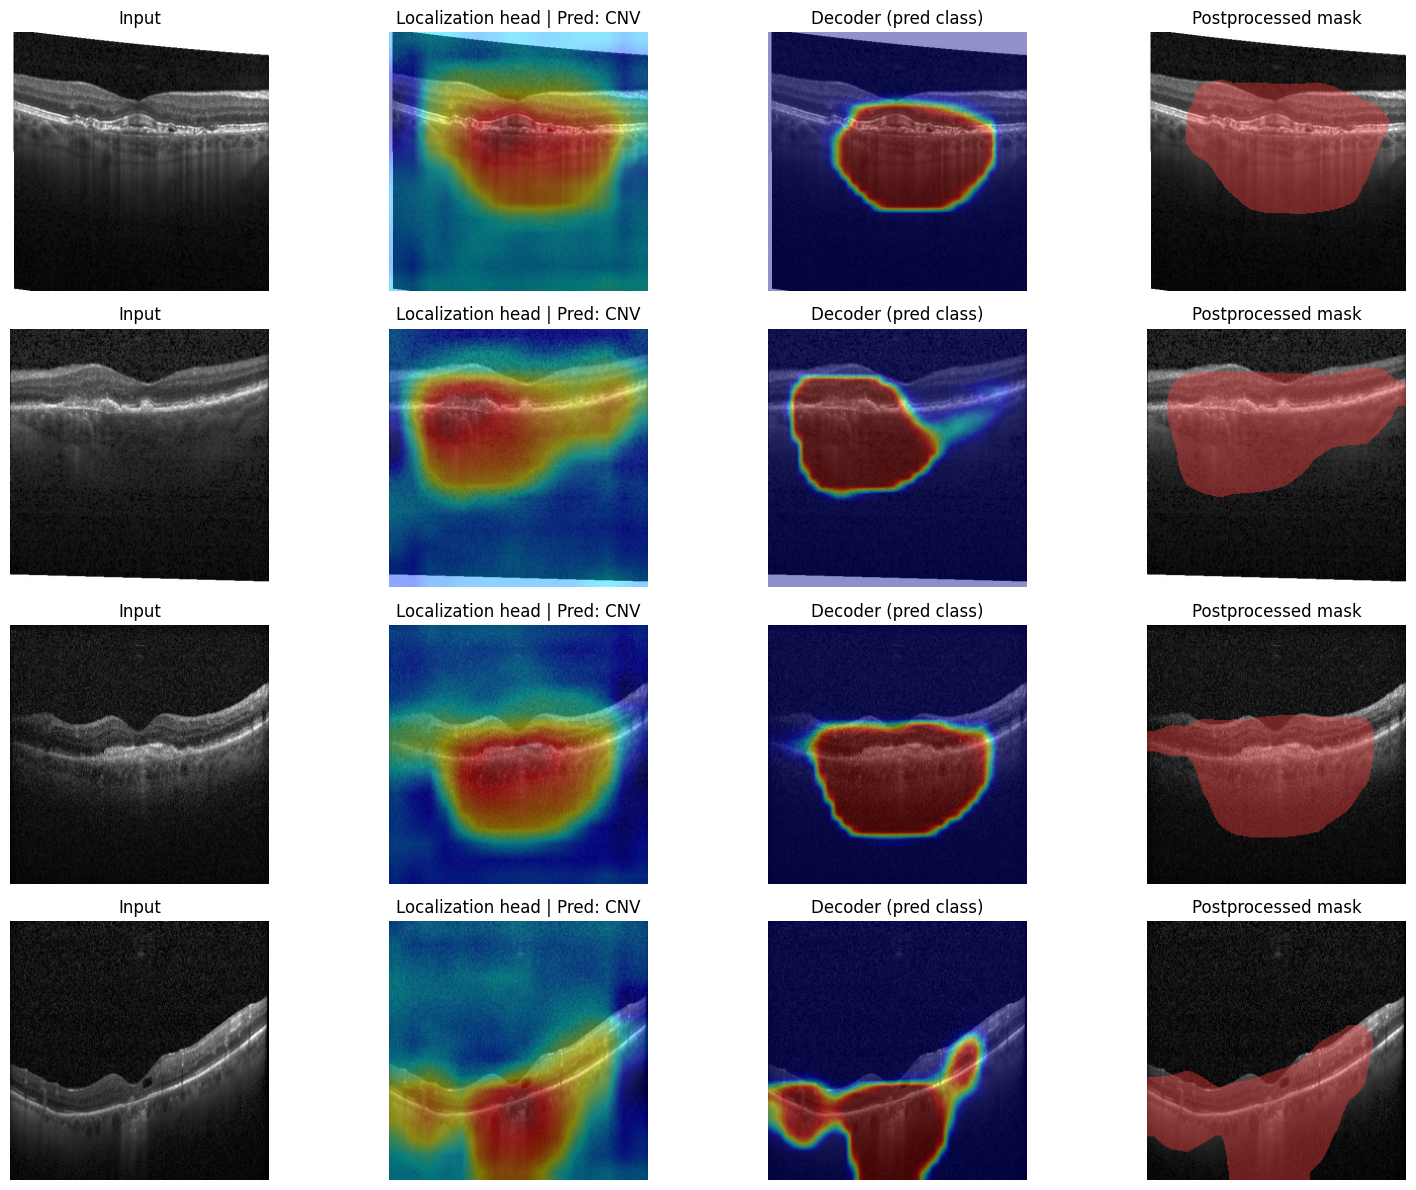

In [9]:
# 🚀 Train / Test / Visualize (final)
assert cfg.data_root != "", "cfg.data_root is empty"

dm  = OCTDataModule(cfg); dm.setup()
lit = LitV4(cfg)

logger = TensorBoardLogger(save_dir="tb_logs", name=cfg.project, version=cfg.run_name)
# IMPORTANT: monitor a metric you log; here we use val/cls_acc
ckpt  = ModelCheckpoint(monitor="val/cls_acc", mode="max", save_top_k=cfg.save_top_k,
                        filename="{epoch}-{val_cls_acc:.4f}")
early = EarlyStopping(monitor="val/cls_acc", mode="max", patience=4)
lrm   = LearningRateMonitor(logging_interval="epoch")

trainer = pl.Trainer(
    max_epochs=cfg.max_epochs,
    precision=cfg.precision,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    logger=logger,
    callbacks=[ckpt, early, lrm],
    log_every_n_steps=20
)

trainer.fit(lit, dm)
trainer.test(lit, datamodule=dm, ckpt_path="best")

# Visualize a test batch with the UPDATED plot_batch() you pasted earlier
batch = next(iter(dm.test_dataloader()))
plot_batch(lit, batch, nshow=4, show_mil=False)


In [10]:
from google.colab import files
uploaded = files.upload()   # will prompt you to select a file from your laptop

Saving Screenshot 2025-08-30 155518.png to Screenshot 2025-08-30 155518.png
Saving Screenshot 2025-08-30 155628.png to Screenshot 2025-08-30 155628.png
Saving Screenshot 2025-08-30 155818.png to Screenshot 2025-08-30 155818.png
Saving Screenshot 2025-08-30 160208.png to Screenshot 2025-08-30 160208.png
Saving Screenshot 2025-08-30 160553.png to Screenshot 2025-08-30 160553.png


In [11]:
from torchvision import transforms
from PIL import Image
import torch
import cv2
import matplotlib.pyplot as plt

# Preprocessing (must match your training!)
preprocess = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((cfg.img_size, cfg.img_size)),   # same size you trained with
    transforms.ToTensor(),
    transforms.Normalize(mean=[cfg.normalize_mean], std=[cfg.normalize_std]),
])

def run_custom_inference(img_path, lit, device="cuda"):
    lit.eval().to(device)

    # Load + preprocess
    img_pil = Image.open(img_path).convert("L")
    x = preprocess(img_pil).unsqueeze(0).to(device)  # [1,1,H,W]

    # Graph
    A_hat, coords = lit._get_graph(device)

    with torch.no_grad():
        (log1,A1),(log2,A2),loc_maps,logits,Xg,x2,x3,seg_logits = lit.base(x, A_hat, coords)

    pred_class = logits.argmax(1).item()

    # --- Heatmap from localization head ---
    loc = loc_maps[0, pred_class].cpu().numpy()
    loc = (loc - loc.min()) / (loc.max() + 1e-6)
    loc_up = cv2.resize(loc, (x.shape[-1], x.shape[-2]), interpolation=cv2.INTER_LINEAR)

    # --- Heatmap from decoder ---
    dec = torch.softmax(seg_logits, dim=1)[0, pred_class].cpu().numpy()
    dec = (dec - dec.min()) / (dec.max() + 1e-6)

    return img_pil, loc_up, dec, pred_class


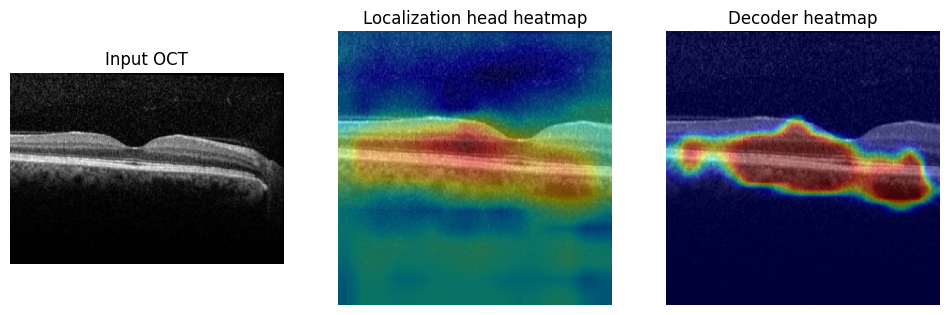

In [17]:
# If you uploaded directly:
img_path = "/content/Screenshot 2025-08-30 155818.png"

# If on Google Drive:
# img_path = "/content/drive/MyDrive/OCT_papers/sample1.png"

img_pil, loc_map, dec_map, pred_class = run_custom_inference(img_path, lit)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(img_pil, cmap="gray"); plt.axis("off"); plt.title("Input OCT")
plt.subplot(1,3,2); plt.imshow(img_pil, cmap="gray"); plt.imshow(loc_map, cmap="jet", alpha=0.45); plt.axis("off"); plt.title("Localization head heatmap")
plt.subplot(1,3,3); plt.imshow(img_pil, cmap="gray"); plt.imshow(dec_map, cmap="jet", alpha=0.45); plt.axis("off"); plt.title("Decoder heatmap")
plt.show()
